# **Import Part:**

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from typing import Tuple
import seaborn as sns
sns.set(context="talk", style="darkgrid", palette="hls", font="sans-serif", font_scale=1.05)

# **Particle Swarm Optimization:**

In [2]:
class ParticleSwarmOpt:
    def __init__(self, linear_velocity=False, dynamic_velocity=False, 
                 random_velocity=False, kmeans_usage=False, num_clusters=3, 
                 input_data=None, w=0.73, c1=1.47, c2=1.47):
        # Kmeans or random cluster mode:
        if kmeans_usage is True:
            pso_kmeans = KMeans(n_clusters=num_clusters)
            pso_kmeans.fit(input_data)
            self.centroids_position = pso_kmeans.cluster_centers_
        elif kmeans_usage is False:
            self.centroids_position = input_data[np.random.choice(list(range(len(input_data))), num_clusters)]

        # Assign the number of clusters that we have!
        self.num_clusters = num_clusters

        # For each cluster we have a centroid which is the point that will represent that exact cluster
        # set Initialization for the best Fitness Score to : IEEE infinity
        self.best_fitness_value = np.inf

        # set the initialization for the best Centroid Positions so far:
        self.best_centroid_positions = self.centroids_position.copy()
        # Set the initial Velocity of the particle to zero:
        if random_velocity is False:
            # NumPy.zeros_like(array) : Return an array of zeros with the same shape and type as a given array.
            self.particle_velocity = np.zeros_like(self.centroids_position)
        elif random_velocity is True:
            self.particle_velocity = np.random.rand(*self.centroids_position.shape)
        # Initializae the Best clustering for the input_data so far:
        self.best_data_clustering = None
        self.dynamic_velocity = dynamic_velocity
        self.linear_velocity = linear_velocity


        # Set Confidence Coefficients: C0(W), C1, C2 (PSO parameters)
        if self.dynamic_velocity is False:
            self.w = w
        else:
            self.w = 0
        self.c1 = c1
        self.c2 = c2

    def updating_velocity(self, best_centroid_positions:np.ndarray, iter:int):
        '''
        inputs:
            best_centroid_positions: numpy array
                it's a vector of best centroid positions among all particles so far!
        ------------------------------------
        outputs: Nothing
            it basicly updates the self.particle_velocity!
        '''
        if self.dynamic_velocity is True:
            if self.linear_velocity is True:
                # print("Iter: ", iter)
                # print("Dynamic Linear Velocity")
                self.w = iter / 1000
            elif self.linear_velocity is False:
                # print("Iter: ", iter)
                # print("Dynamic non-Linear Velocity")
                self.w = 1/(1 + np.exp(-iter))

        self.particle_velocity = (self.w * self.particle_velocity) + (
            self.c1 * np.random.random() * (self.best_centroid_positions - self.centroids_position) + 
            self.c2 * np.random.random() * (best_centroid_positions - self.centroids_position)
        )


    def calculate_fitness(self, clusters:np.ndarray, distances:np.ndarray)->float:
        """
        inputs:
            clusters:
            distances:
        -----------------------------
        outputs:
            fitness: returns the calculated fitness based on the given parameters
        """
        fitness = float(0)
        for particle_index in range(self.num_clusters):
            cluster_data_vector = np.where(clusters==particle_index)[0]
            if len(cluster_data_vector):
                distance_vector = sum(distances[particle_index][cluster_data_vector])
                distance_vector /= len(cluster_data_vector)
                fitness += distance_vector
        fitness /= self.num_clusters
        return fitness


    def calculate_data_centroids_distances(self, input_data:np.ndarray) -> np.ndarray:
        """
        inputs:
            input_data : the given data to calculate the distances of them
        --------------------------
        This function is going to calculate the Euclidean distance between given 
        data and the centroids.
        --------------------------
        outputs:
            distances: an array that represents the distances

        """
        calculated_distances = []
        for centroid in self.centroids_position:
            # here we will calculate the Euclidean distance :-> square root of sum of absolute squares
            distance = np.linalg.norm(input_data - centroid, axis=1)
            calculated_distances.append(distance)
        calculated_distances = np.array(calculated_distances)
        return calculated_distances

    
    def updating_best_score(self, input_data:np.ndarray):
        """
        inputs: 
            input_data : the givent data (Numpy Array)
        ----------------------
        This function is going to Update the best score we had so far based on 
        the fitness function that was given on the original given paper.
        ----------------
        outputs : Nothing (Just updating parameters)
        """
        # first we want to find out which data points belong to which cluster we have
        points_to_centroids_distances = self.calculate_data_centroids_distances(input_data=input_data)

        # find the Minimum distance between the centroids and data points
        # it will indicate for us that which point belongs to which cluster
        points_cluster = np.argmin(points_to_centroids_distances, axis=0)
        points_cluster_index = np.unique(points_cluster)

        while len(points_cluster_index) != self.num_clusters:
            deleted_clusters = np.where(np.isin(np.arange(self.num_clusters), points_cluster_index)==False)[0]
            self.centroids_position[deleted_clusters] = input_data[np.random.choice(list(range(len(input_data))), len(deleted_clusters))]
            # print("Centroid position: ", self.centroids_position[deleted_clusters])
            points_to_centroids_distances = self.calculate_data_centroids_distances(input_data=input_data)
            # print("points_to_centroids_distances: ", points_to_centroids_distances)
            points_cluster = np.argmin(points_to_centroids_distances, axis=0)
            # print("Points Cluster: ", points_cluster)
            points_cluster_index = np.unique(points_cluster)
        # Calculate the fitness of new centroid positioning:
        new_clusters_fitness = self.calculate_fitness(clusters=points_cluster, distances=points_to_centroids_distances)
        # Now we will check that is the new clusters better than the previous best that we have:
        if new_clusters_fitness < self.best_fitness_value:
            self.best_fitness_value = new_clusters_fitness
            self.best_centroid_positions = self.centroids_position.copy()
            self.best_data_clustering = points_cluster.copy()
    
    def reposition_centroids(self, new_position, iteration=0):
        self.updating_velocity(best_centroid_positions=new_position, iter=iteration)
        new_positions = self.centroids_position + self.particle_velocity
        self.centroids_position = new_positions.copy()

# **Particle Swarm Optimization Clustering:**

In [3]:
class ParticleSwarmOptClustering:
    def __init__(self, num_clusters:int, num_particles:int, input_data:np.ndarray, 
                 linear_velocity=False, dynamic_velocity=False, 
                 random_velocity=False,
                 is_kmeans=True, w=0.73, c1=1.47, c2=1.47):
        '''
        inputs:
            num_clusters: int
                number of clusters
            num_particles: int
                number of particles
            
        -----------------------------------
        this function will set and initializes the class!
        -----------------------------------
        outputs:
            Nothing (Just set the parameters)
        '''
        self.num_clusters = num_clusters
        self.num_particles = num_particles
        self.input_data = input_data
        self.particles = []
        # Set the Global Best Position:
        self.global_best_position = None
        # Set the Global Best Fitness (Set it to IEEE infinity):
        self.global_best_fitness = np.inf
        # Set the initial best data clustering so far! (for each data point will contain the cluster number)
        self.global_best_clustering = None

        self.is_kmeans = is_kmeans
        self.linear_velocity = linear_velocity 
        self.dynamic_velocity = dynamic_velocity
        self.random_velocity = random_velocity
        self.global_best_record = []

        self.w = w
        self.c1 = c1
        self.c2 = c2

        self.particle_generation()

    def printing_initialize(self, iterations, plot):
        pass
    
    def particle_generation(self):
        '''
        inputs: Nothing
        ------------------------------
        This function Generates particles with k clusters
        ------------------------------
        outputs: Nothing
        '''
        for i in range(self.num_particles):
            particle_swarm = ParticleSwarmOpt(linear_velocity=self.linear_velocity, 
                                dynamic_velocity=self.dynamic_velocity, 
                                random_velocity=self.random_velocity, 
                                num_clusters=self.num_clusters, 
                                input_data=self.input_data, 
                                kmeans_usage=self.is_kmeans, w=self.w,
                                c1=self.c1, c2=self.c2)
            self.particles.append(particle_swarm)

    def global_best_updating(self, particle):
        if particle.best_fitness_value < self.global_best_fitness:
            self.global_best_fitness = particle.best_fitness_value
            self.global_best_position = particle.best_centroid_positions.copy()
            self.global_best_clustering = particle.best_data_clustering.copy()

    def start_clustering(self, iterations=3000, plot=True)->Tuple[np.ndarray, float]:
        '''
        '''
        self.printing_initialize(iterations=iterations, plot=plot)
        results_progress = []
        for idx in range(0, iterations):
            self.global_best_record.append(self.global_best_fitness)
            if idx % 100 == 0:
                clusters = self.global_best_clustering
                print("Iteration:=> ", idx, " | Global Best:=> ", self.global_best_fitness)
                print("Best clusters so far:=> ", clusters)
                if plot:
                    centroids = self.global_best_position
                    if clusters is not None:
                        plt.figure(figsize=(8, 6))
                        plt.scatter(self.input_data[:, 0], self.input_data[:, 1], c=clusters, cmap='viridis')
                        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
                        # print("Clusters: ", clusters)
                        # plt.scatter(self.input_data[:, 0], self.input_data[:, 1], c=clusters, alpha=.8, lw=lw)
                        plt.show()
                    else:  # if there is no clusters yet ( iteration = 0 ) plot the data with no clusters
                        plt.scatter(self.input_data[:, 0], self.input_data[:, 1])
                        plt.show()

            for particle in self.particles:
                particle.updating_best_score(input_data=self.input_data)
                self.global_best_updating(particle=particle)

            for particle in self.particles:
                particle.reposition_centroids(new_position=self.global_best_position, iteration=idx)
            results_progress.append([self.global_best_position, self.global_best_clustering, self.global_best_fitness])

        return self.global_best_clustering, self.global_best_fitness, self.global_best_record

## **Calculate Accuracy:**

In [4]:
def calculate_accuracy(input_array, num_clusters=3):
    array_length = len(input_array)
    split_parts = int(array_length / num_clusters)
    total_corrects = 0
    uniques = []
    frequents = []
    for i in range(num_clusters):
        items = input_array[i*split_parts:(i+1)*split_parts]
        # print("Split parts: ", len(items))
        unique, counts = np.unique(items, return_counts=True)
        frequent_label = np.bincount(items).argmax()
        if frequent_label not in frequents:
            total_corrects += np.amax(counts)
        res = dict(zip(unique, counts))
        frequents.append(frequent_label)
    acc = total_corrects / array_length
    print("===========================================")
    print("===========================================")
    print("| ===>>> The Accuracy is :=> {0:.2f}% <<<=== |".format(acc*100))
    print("===========================================")
    print("===========================================")


def plot_global_best(records):
    """
    ----------------
    This function will draw the temperature decrease plot for us!
    -----------------
    """
    plt.figure(figsize=(16, 10))
    # plt.subplot(121)
    plt.plot(records, 'r')
    # plt.title("States")
    plt.ylabel("Fitness")
    plt.xlabel("Iteration")
    plt.title("Global Best Results")
    plt.show()

Iteration:=>  0  | Global Best:=>  inf
Best clusters so far:=>  None


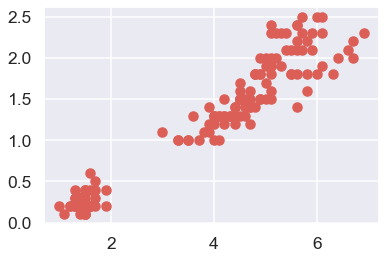

Iteration:=>  100  | Global Best:=>  0.3672591851091438
Best clusters so far:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


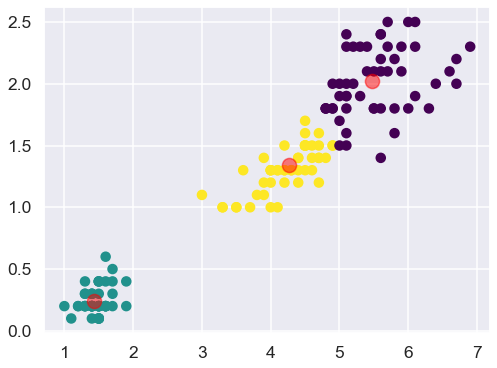

Iteration:=>  200  | Global Best:=>  0.36725891333587174
Best clusters so far:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


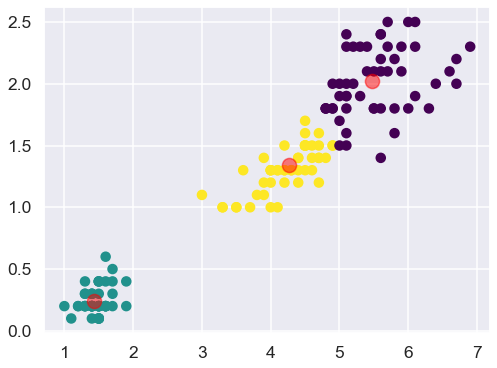

Iteration:=>  300  | Global Best:=>  0.3672588300666802
Best clusters so far:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


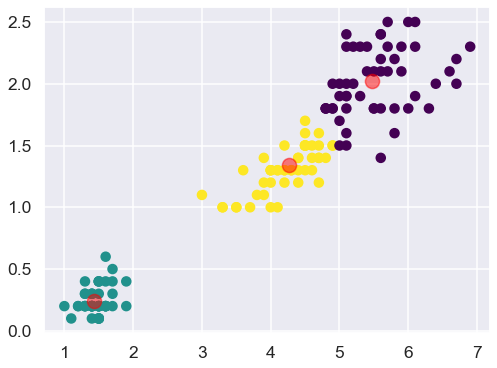

Iteration:=>  400  | Global Best:=>  0.36725883006411225
Best clusters so far:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


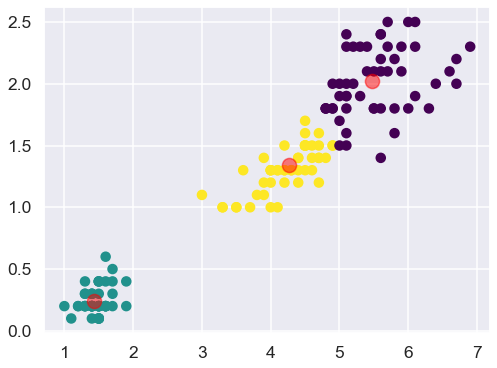

Iteration:=>  500  | Global Best:=>  0.36725883004234294
Best clusters so far:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


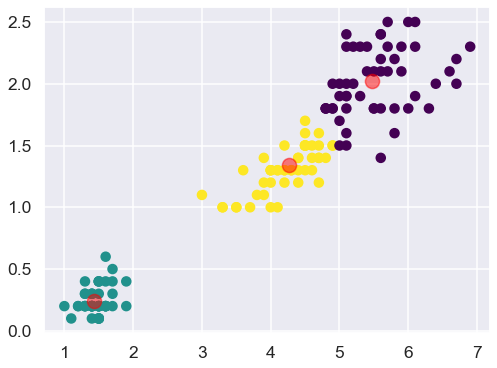

Iteration:=>  600  | Global Best:=>  0.36725883004233834
Best clusters so far:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


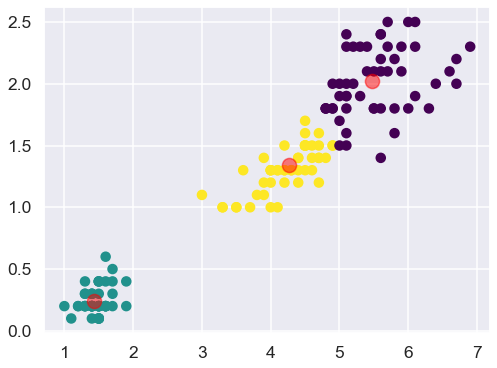

Iteration:=>  700  | Global Best:=>  0.36725883004233667
Best clusters so far:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


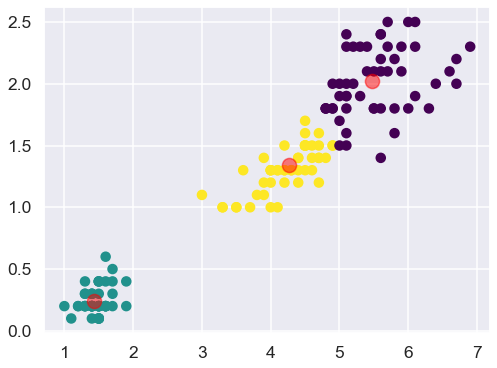

Iteration:=>  800  | Global Best:=>  0.36725883004233667
Best clusters so far:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


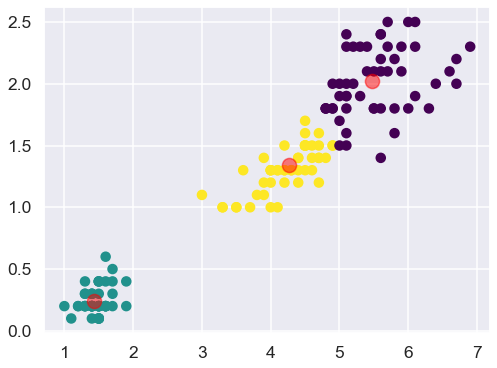

Iteration:=>  900  | Global Best:=>  0.36725883004233656
Best clusters so far:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


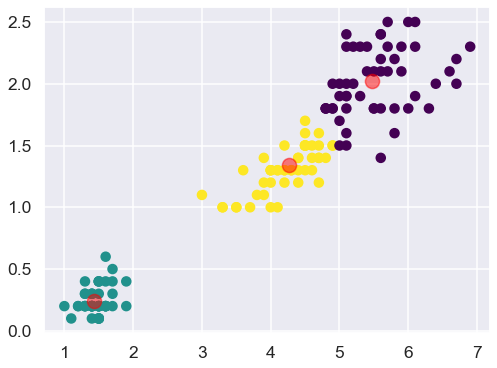

| ===>>> The Accuracy is :=> 97.33% <<<=== |
| Final Cluster Result:=>  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
|------------------------------------------------------------|
| Runtime of the program is:===> 5.8085 sec. |
|------------------------------------------------------------|


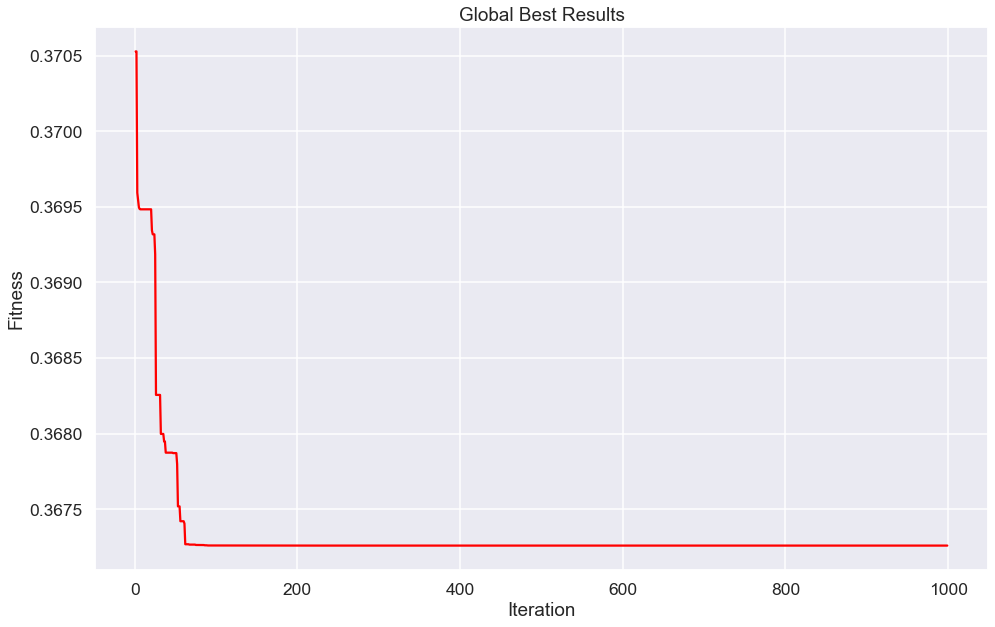

In [6]:
def main():
    plot = True
    data_points = pd.read_csv('iris.txt', sep=',', header=None)
    clusters = data_points[4].values
    data_points = data_points.drop([4], axis=1)
    # if you want to plot you can only show 2 points! so will use 2 points of data
    if plot:
        data_points = data_points[[2, 3]]
    # convert to numpy 2d array
    data_points = data_points.values
    # starting time
    start = time.time()
    pso = ParticleSwarmOptClustering(num_clusters=3, num_particles=10, 
                    input_data=data_points, is_kmeans=True, 
                    linear_velocity=True, dynamic_velocity=False, 
                    random_velocity=False)
    global_best_clustering, best_global_best, global_best_record = pso.start_clustering(iterations=1000, plot=plot)
    # end time
    end = time.time()
    calculate_accuracy(global_best_clustering)
    print("=============================================================")
    print("| Final Cluster Result:=> ", global_best_clustering)
    print("==============================================================")
    # total time taken
    print("==============================================================")
    print("|------------------------------------------------------------|")
    print("| Runtime of the program is:===> {0:.4f} sec. |".format(end-start))
    print("|------------------------------------------------------------|")
    print("==============================================================")
    print("==============================================================")
    plot_global_best(records=global_best_record)

if __name__ == "__main__":
    main()